# 1. Imports

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data_final.csv")
df.head()

,PERMNO,date,SICCD,RET,vwretd,SICCD_peers,RET_peers,date_rel,RET_neigh,Mkt_RF,SMB,HML,RMW,CMA,RF
0,10032,20170227,3670.0,-0.003292,0.001999,3670.0,0.007154,-250,-0.002337,0.0022,0.0085,-0.0033,-0.0038,-0.0015,0.00002
1,10032,20170228,3670.0,-0.025209,-0.004651,3670.0,-0.022114,-249,-0.008818,-0.0042,-0.0136,0.0016,-0.0001,-0.0020,0.00002
2,10032,20170301,3670.0,0.022650,0.013383,3670.0,0.021281,-248,0.024245,0.0147,0.0052,0.0077,-0.0054,0.0054,0.00001
3,10032,20170302,3670.0,-0.007848,-0.006866,3670.0,-0.008909,-247,-0.009514,-0.0070,-0.0054,-0.0090,0.0063,-0.0043,0.00001
4,10032,20170303,3670.0,-0.005273,0.000944,3670.0,-0.001480,-246,-0.000025,0.0009,-0.0018,0.0014,-0.0006,-0.0010,0.00001


# 2. Features correlation matrix

In [3]:
corr_mat = df.corr()

<AxesSubplot:>

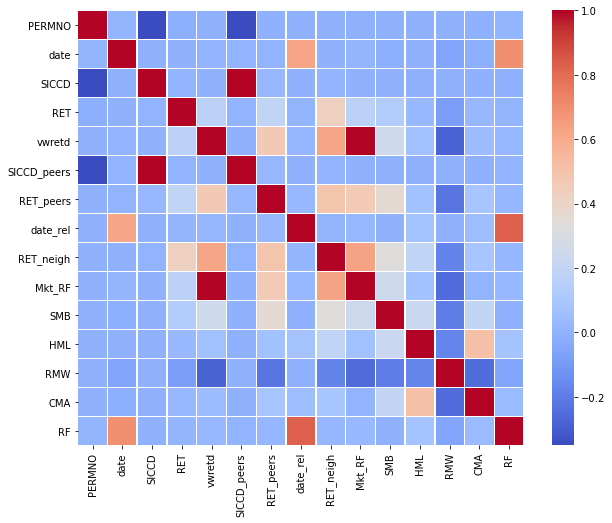

In [4]:
plt.rcParams["figure.figsize"] = (10, 8)
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', linewidths=.5)

# 3. Standard linear models

## 3.1. Features and model names

In [5]:
features = [['vwretd'], ['vwretd', 'RET_peers'], ['vwretd','RET_neigh'],
           ['vwretd', 'SMB','HML'],
           ['vwretd','SMB','HML','RMW','CMA']
           ]

names_linear = ['MM', 'MMP', 'MMN', 'MMFF3', 'MMFF5']

## 3.2. Model training

In [6]:
PERMNO_list = pd.unique(df['PERMNO'])

output = np.empty((len(df), len(names_linear)))

from sklearn.linear_model import LinearRegression
LinearModel = LinearRegression(fit_intercept=True)

for model in range(len(features)):
    
    ARs_linear = list()
    
    for i in range(len(PERMNO_list)):
        
        cur_PERMNO = PERMNO_list[i]
        cur_PERMNO_data = df[df['PERMNO']==cur_PERMNO]
            
        feat = features[model]
    
        X, y  = cur_PERMNO_data[feat].to_numpy().reshape(-1,len(feat)), cur_PERMNO_data['RET'].to_numpy().reshape(-1,1)
        X_train, y_train = X[:-1,:], y[:-1,:]

        estimModel = LinearModel.fit(X_train, y_train)
        stock_ARs = (y - estimModel.predict(X)).reshape(-1).tolist()

        ARs_linear.extend(stock_ARs)

    output[:,model] = np.array(ARs_linear)

ARs_linear = pd.DataFrame(output, columns=names_linear)
df = pd.concat([df, ARs_linear], axis=1)

## 3.3. Abnormal returns

In [7]:
AR_estim = df[df['date_rel']<0][names_linear]
AR_estim.head()

,MM,MMP,MMN,MMFF3,MMFF5
0,-0.005095,-0.005926,0.001816,-0.012461,-0.012583
1,-0.019871,-0.017072,-0.011642,-0.009196,-0.009344
2,0.008622,0.008042,-0.011777,0.007314,0.007475
3,-0.000131,-0.000249,0.006173,0.001683,0.001705
4,-0.005943,-0.005482,-0.004226,-0.004213,-0.004315


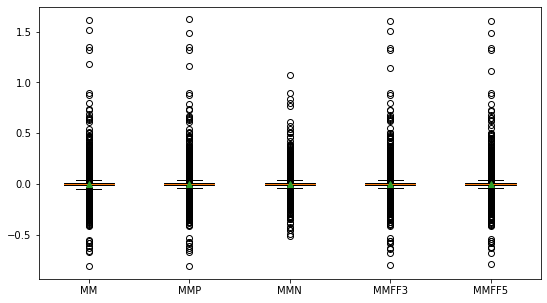

In [8]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR_estim.values, labels = AR_estim.columns, showmeans=True)
plt.show()

In [9]:
AR_event = df[df['date_rel']==0][names_linear]

In [10]:
AR_event.head()

,MM,MMP,MMN,MMFF3,MMFF5
250,-0.007471,-0.009529,-0.003329,-0.002997,-0.002989
501,-0.006440,-0.005782,-0.009164,-0.002879,-0.002163
752,0.036636,0.032759,0.027070,0.030656,0.030036
1003,-0.012668,-0.008733,-0.018157,-0.008801,-0.008655
1254,-0.048857,-0.053680,-0.028802,-0.050036,-0.049874


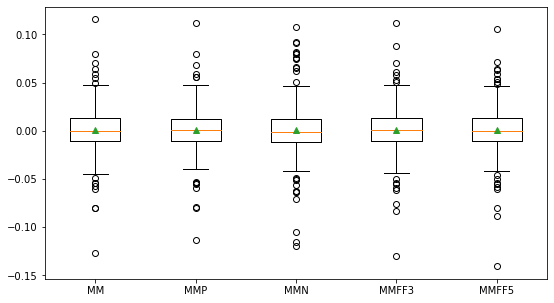

In [11]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR_event.values, labels = AR_event.columns, showmeans=True)
plt.show()

# 4. Alternative models

## 4.1. Model definitions

In [12]:
def get_models():
    models, names = list(), list()
    # Ridge
    models.append(RidgeCV())
    names.append('Ridge')
    
    # Lasso
    models.append(LassoCV())
    names.append('Lasso')
    
    # ElasticNet
    models.append(ElasticNetCV())
    names.append('ElasticNet')    
    
    # DT
    models.append(DecisionTreeRegressor(max_depth=5, min_samples_split=0.4))
    names.append('DT')
    
    # RF
    models.append(RandomForestRegressor(max_depth=5, min_samples_split=0.4))
    names.append('RandForest')
    
    return models, names

## 4.2. Model training

In [13]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


models, names = get_models()

output = np.empty((len(df), len(models)))

features = ['vwretd','RET_peers','RET_neigh','SMB','HML','RMW','CMA']
   
for model in range(len(models)):
    
    ARs_model = list()

    for stock in range(len(PERMNO_list)):

        cur_PERMNO = PERMNO_list[stock]
        cur_PERMNO_data = df[df['PERMNO']==cur_PERMNO]

        X, y  = cur_PERMNO_data[features].to_numpy().reshape(-1,len(features)), cur_PERMNO_data['RET'].to_numpy()
        X_train, y_train = X[:-1,:], y[:-1]

        estimModel = models[model].fit(X_train, y_train)
        ARs = (y - estimModel.predict(X)).reshape(-1).tolist()

        ARs_model = ARs_model + ARs

    output[:,model] = np.array(ARs_model)

ARs_altModels = pd.DataFrame(output, columns=names)
df_all = pd.concat([df, ARs_altModels], axis=1)

In [14]:
df_all.head()

,PERMNO,date,SICCD,RET,vwretd,SICCD_peers,RET_peers,date_rel,RET_neigh,Mkt_RF,...,MM,MMP,MMN,MMFF3,MMFF5,Ridge,Lasso,ElasticNet,DT,RandForest
0,10032,20170227,3670.0,-0.003292,0.001999,3670.0,0.007154,-250,-0.002337,0.0022,...,-0.005095,-0.005926,0.001816,-0.012461,-0.012583,-0.004528,-0.004925,-0.005238,-0.007410,-0.000796
1,10032,20170228,3670.0,-0.025209,-0.004651,3670.0,-0.022114,-249,-0.008818,-0.0042,...,-0.019871,-0.017072,-0.011642,-0.009196,-0.009344,-0.021196,-0.007108,-0.007233,-0.005616,-0.010660
2,10032,20170301,3670.0,0.022650,0.013383,3670.0,0.021281,-248,0.024245,0.0147,...,0.008622,0.008042,-0.011777,0.007314,0.007475,0.016794,-0.006323,-0.005526,0.012591,0.012340
3,10032,20170302,3670.0,-0.007848,-0.006866,3670.0,-0.008909,-247,-0.009514,-0.0070,...,-0.000131,-0.000249,0.006173,0.001683,0.001705,-0.005316,0.005134,0.004807,0.011745,0.006701
4,10032,20170303,3670.0,-0.005273,0.000944,3670.0,-0.001480,-246,-0.000025,0.0009,...,-0.005943,-0.005482,-0.004226,-0.004213,-0.004315,-0.005220,-0.003606,-0.003609,-0.004693,-0.004791


In [15]:
model_names_all = names_linear + names

## 4.3. Abnormal returns (standard + alternative models)

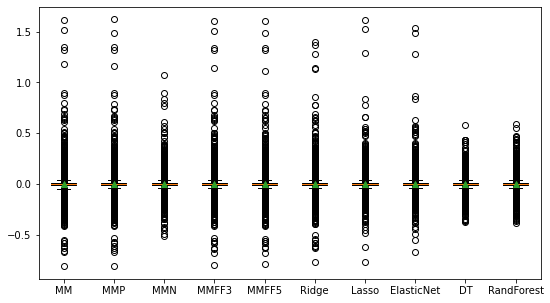

In [16]:
ARs_estim = df_all[df_all['date_rel']<0][model_names_all]
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(ARs_estim.values, labels=model_names_all, showmeans=True)
plt.show()

In [17]:
AR0s = df_all[df_all['date_rel']==0][model_names_all]

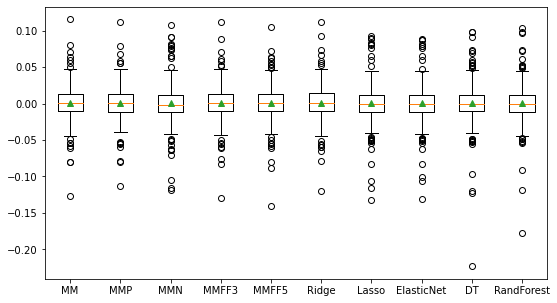

In [18]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR0s.values, labels=model_names_all, showmeans=True)
plt.show()

In [19]:
ARs_estim = df_all[df_all['date_rel']<0][['PERMNO']+model_names_all]
RMSEs_estim = ARs_estim.groupby('PERMNO').std().reset_index()
RMSEs_estim.head()

,PERMNO,MM,MMP,MMN,MMFF3,MMFF5,Ridge,Lasso,ElasticNet,DT,RandForest
0,10032,0.011700,0.011549,0.010780,0.011118,0.011116,0.012319,0.010466,0.010471,0.008735,0.009745
1,10516,0.011494,0.011311,0.011053,0.011231,0.011182,0.011742,0.010992,0.010885,0.010927,0.010672
2,12009,0.022502,0.018145,0.019999,0.021467,0.021078,0.018820,0.017327,0.017331,0.018560,0.018646
3,12356,0.033857,0.033747,0.027816,0.033105,0.032908,0.032444,0.027223,0.027226,0.024209,0.025454
4,12358,0.055878,0.055766,0.049005,0.055830,0.055659,0.055186,0.048133,0.048136,0.045129,0.045019


In [20]:
ARs_test = df_all[df_all['date_rel']==0][['PERMNO']+model_names_all]
ARs_test.head()

,PERMNO,MM,MMP,MMN,MMFF3,MMFF5,Ridge,Lasso,ElasticNet,DT,RandForest
250,10032,-0.007471,-0.009529,-0.003329,-0.002997,-0.002989,0.002625,-0.003088,-0.003084,-0.002122,-0.002294
501,10516,-0.006440,-0.005782,-0.009164,-0.002879,-0.002163,-0.013612,-0.010045,-0.006933,-0.009103,-0.009876
752,12009,0.036636,0.032759,0.027070,0.030656,0.030036,0.032763,0.028732,0.028899,0.025225,0.025778
1003,12356,-0.012668,-0.008733,-0.018157,-0.008801,-0.008655,-0.012284,-0.019437,-0.019532,-0.008731,-0.016223
1254,12358,-0.048857,-0.053680,-0.028802,-0.050036,-0.049874,-0.051876,-0.033908,-0.034564,-0.052179,-0.047289


## 4.4. Model evaluation

- For each model a x% abnormal return is created by adding x% shock to the date 0 actual return.
- Shock values are: -0.1, -0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05, 0.1
- Shock value 0 aims at testing the specification of the various models (Type 1 error)
- Other shock values aim at testing the power of the various models (Type 2 error)

The null hypothesis $AR^{(m)}_{i,0}=0$ is rejected for stock $i$ and model $(m)$ if $\frac{AR^{(m)}_{i,0}}{RMSE_i^{(m)}}>z_{\alpha}$

In [21]:
shocks = [-0.1, -0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05, 0.1]
from scipy.stats import norm
z_alpha = norm.ppf(0.975)

In [22]:
rejection_rates = np.empty((len(shocks), len(ARs_test.columns)-1))

In [23]:
for th in range(len(shocks)):
    z_score = (ARs_test.iloc[:,1:].to_numpy() + shocks[th])/ RMSEs_estim.iloc[:,1:].to_numpy()
    T_spec = np.sum(abs(z_score) > z_alpha, axis=0)
    freq_reject = T_spec / z_score.shape[0]
    rejection_rates[th,] = freq_reject

In [24]:
res = pd.DataFrame(rejection_rates, columns=model_names_all)
res.index = shocks
res

,MM,MMP,MMN,MMFF3,MMFF5,Ridge,Lasso,ElasticNet,DT,RandForest
-0.10,0.832031,0.843750,0.875000,0.847656,0.847656,0.835938,0.871094,0.871094,0.906250,0.890625
-0.05,0.558594,0.570312,0.640625,0.574219,0.570312,0.562500,0.648438,0.648438,0.660156,0.656250
-0.02,0.140625,0.171875,0.226562,0.164062,0.175781,0.140625,0.222656,0.214844,0.242188,0.207031
-0.01,0.054688,0.062500,0.085938,0.062500,0.070312,0.066406,0.089844,0.093750,0.101562,0.074219
0.00,0.019531,0.027344,0.054688,0.027344,0.023438,0.039062,0.050781,0.046875,0.058594,0.054688
0.01,0.054688,0.058594,0.097656,0.046875,0.054688,0.070312,0.093750,0.093750,0.109375,0.093750
0.02,0.140625,0.144531,0.214844,0.144531,0.144531,0.167969,0.226562,0.222656,0.246094,0.222656
0.05,0.601562,0.632812,0.667969,0.632812,0.632812,0.621094,0.675781,0.671875,0.695312,0.695312
0.10,0.843750,0.851562,0.867188,0.855469,0.859375,0.863281,0.871094,0.871094,0.917969,0.898438


## 4.5. Confidence interval for rejection rate

Wald confidence interval for a binomial proportion ($p$):
$$
p \pm z \times \sqrt{\frac{p(1-p)}{n}}
$$
where $z$ is the confidence level (1.96 for a 95% confidence interval).

In [25]:
import math

# Sample data
number_rejections = int(5/100*256)+1 
total_trials = 256

# Sample proportion
p = number_rejections / total_trials

confidence_level = 0.95

# Z score based on confidence level
Z = norm.ppf((1 + confidence_level) / 2)

# Standard error
standard_error = math.sqrt((p * (1 - p)) / total_trials)

# Margin of error
margin_of_error = Z * standard_error

# Confidence interval
lower_limit = round((p - margin_of_error),3)
upper_limit = round((p + margin_of_error),3)

print(f"Sample Proportion: {p}")
print(f"Confidence Interval: [{lower_limit}, {upper_limit}]")

Sample Proportion: 0.05078125
Confidence Interval: [0.024, 0.078]
